#### In this notebook:

1. We will first explore the dataset provided
2. We will create models to predict the hourly bike rental demand. 
3. We will also make predictions for hourly demand in the test set which you can submit in the solution_checker.xlsx file to generate rmsle score. 

Let's start by importing the libraries that we will be using.

In [121]:
# Importing all libraries
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import calendar
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [104]:
# Loading out data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [105]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


In [106]:
train.shape, test.shape

((12980, 12), (4399, 11))

In [107]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [108]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered'],
      dtype='object')

In [109]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

We can infer that all of the variable in the dataset except datetime are numerical variables. Now Let's look at the distribution of our target variable, i.e. count. As it is a numerical variable, let us look at its distribution.

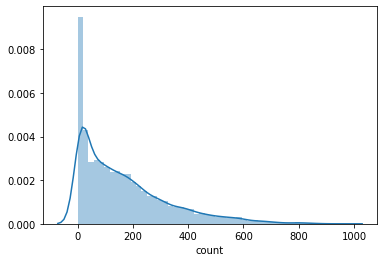

In [110]:
sn.distplot(train["count"]) #skewed towards right

The distribution is skewed towards right and hence we can take log of the variable and see if the distribution becomes normal.

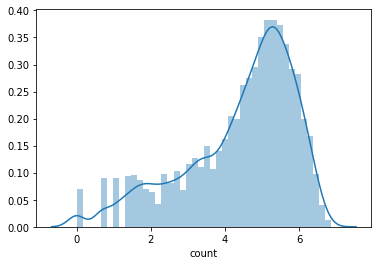

In [111]:
sn.distplot(np.log(train["count"]))

Now the distribution looks less skewed. Let's now explore the variables to have a better understanding of the dataset. We will first explore the variables individually using univariate analysis, then we will look at the relation between various independent variables and the target variable. We will also look at the correlation plot to see which variables affects the target variable most.

Let's first look at the distribution of registered variable to check the number of registered user rentals initiated.

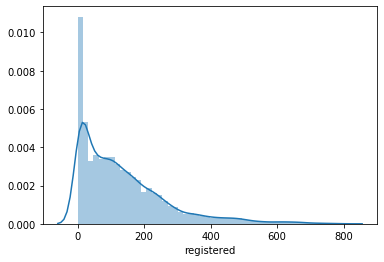

In [112]:
sn.distplot(train["registered"])

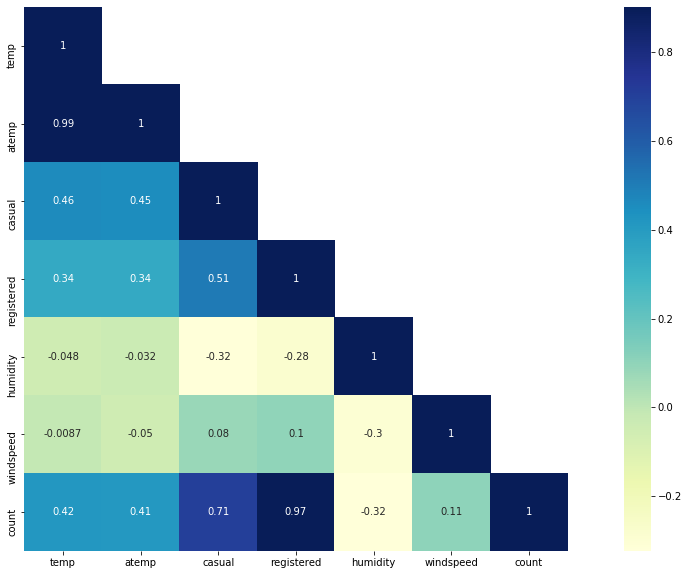

In [113]:
# Biverate Analysis
corr = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu")

# Building our model

In [114]:
# Null values check
train.isnull().sum()


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [117]:
test.isnull().sum()


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
dtype: int64

In [118]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


There are no missing values in the test dataset as well. We can now move further and build our first model. Before that let's first extract some new features using the datetime variable. We can extract the date, hour, month.

In [124]:
# Extracting date, time and month
train["date"] = train.datetime.apply(lambda x : x.split()[0])
train["hour"] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])
train["month"] = train.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [125]:
test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])
test["month"] = test.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

You can also use to_datetime() function from pandas package to convert the date in datetime format and then extract features from it. 

Let's now build a linear regression model to get the predictions on the test data. We have to make the similar changes in test data as we have done for the training data.

In [126]:
# Diving training dataset into training and validation set (15 month & 3month)
training = train[train['datetime']<='2012-03-30 0:00:00']
validation = train[train['datetime']>'2012-03-30 0:00:00']

In [127]:
train = train.drop(['datetime','date', 'atemp'],axis=1)
test = test.drop(['datetime','date', 'atemp'], axis=1)
training = training.drop(['datetime','date', 'atemp'],axis=1)
validation = validation.drop(['datetime','date', 'atemp'],axis=1)

In [128]:
# Linear Regression  Model
from sklearn.linear_model import LinearRegression

In [129]:
model = LinearRegression()

In [130]:
X_train = training.drop('count', 1)
y_train = np.log(training['count'])
X_val = training.drop('count', 1)
y_val = np.log(training['count'])

In [131]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10774, 11), (10774,), (10774, 11), (10774,))

In [132]:
# fit the model on X_train, y_train
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [133]:
pred = model.predict(X_val)

In [134]:
# defining a function which will return the rmsle score
def rmsle(y, y_):
    y = np.exp(y),   # taking the exponential as we took the log of target variable
    y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [136]:
rmsle(y_val,pred)

0.6930366495815723

## Decision Tree

In [137]:
from sklearn.tree import DecisionTreeRegressor

In [138]:
dt_reg = DecisionTreeRegressor(max_depth=5)

In [139]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [140]:
prediction = dt_reg.predict(X_val)

In [143]:
rmsle(y_val, prediction)

0.1270464665298961

The rmsle value has decreased to 0.127. This is a decent score. Let's now make predictions for the test dataset which you can submit in the excel sheet provided to you to generate your score.

In [144]:
test_prediction = dt_reg.predict(test)

In [145]:
final_prediction = np.exp(test_prediction)

In [146]:
submission = pd.DataFrame()

In [147]:
submission['count'] = final_prediction

In [148]:
# creating a count column and saving the predictions in it
submission.to_csv('submission.csv', header=True, index=False)

1. Open the submission.csv file.
2. Copy the values in the count column and paste them in the count column of solution_checker.xlsx file.
3. You will see the rmsle score of the model on test dataset under score column.